In [1]:
## Import Packages
import numpy as np
import _pickle as pk
import warnings
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import matplotlib as mpl
import Area_Avg as aa
from itertools import repeat
from netCDF4 import Dataset
import scipy as sci
import matplotlib.gridspec as gridspec

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table

#plt.rcParams['axes.xmargin'] = 0 #default margin spacing for the edges
mpl.rc('font',size=35,**{'family':'sans-serif','sans-serif':['Arial']})
#mpl.rc('text', usetex=True)
#mpl.rcParams['mathtext.rm'] = 'Arial'
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)
%matplotlib inline

In [2]:
FNET = pk.load(open('Data/CanESM5_p2/amip/ERF/CanESM5_p2_FNET_GAM.pi','rb'))
FNETCS = pk.load(open('Data/CanESM5_p2/amip/ERF/CanESM5_p2_FNETCS_GAM.pi','rb'))
Tas = pk.load(open('Data/CanESM5_p2/amip/ERF/CanESM5_p2_TAS_GAM.pi','rb'))

In [3]:
fluxes = pk.load(open('Data/CanESM5_p2/amip/Fluxes/CanESM5_p2_ALL_uFLUXES_GAM.pi','rb'))
swcld_fbk_amip = pk.load(open(\
    'Data/CanESM5_p2/amip/Fluxes/CanESM5_p2_TrCLsw_FLUX_FB_Grid.pi','rb'))
swcld_fbk = pk.load(open(\
    'Data/CanESM5_p2/Fluxes/CanESM5_p2_TrCLsw_FLUX_FB_Grid.pi','rb'))

swcld_fbk.pop('ECHAM6_ctr')
swcld_fbk.pop('CAM3')
swcld_fbk.pop('CAM5')
    
swcld_fbk_amip.pop('ECHAM6_ctr')
swcld_fbk_amip.pop('CAM3')
swcld_fbk_amip.pop('CAM5')
    
swcld_fbk_ZM = np.mean(list(swcld_fbk.values()),axis=(0,2))
swcld_fbk_amip_ZM = np.mean(list(swcld_fbk_amip.values()),axis=(0,2))

fluxes_std = dict()
fluxes_mn = dict()
for eb in fluxes.keys():
        
    fluxes[eb].pop('ECHAM6_ctr')
    fluxes[eb].pop('CAM3')
    fluxes[eb].pop('CAM5')
        
    fluxes_std[eb] = np.std(list(fluxes[eb].values()),axis=0)
    fluxes_mn[eb] = np.mean(list(fluxes[eb].values()),axis=0)

In [4]:
lwcld_fbk_amip = pk.load(open(\
    'Data/CanESM5_p2/amip/Fluxes/CanESM5_p2_TrCLlw_FLUX_FB_Grid.pi','rb'))
lwcld_fbk = pk.load(open(\
    'Data/CanESM5_p2/Fluxes/CanESM5_p2_TrCLlw_FLUX_FB_Grid.pi','rb'))

lwcld_fbk.pop('ECHAM6_ctr')
lwcld_fbk.pop('CAM3')
lwcld_fbk.pop('CAM5')
    
lwcld_fbk_amip.pop('ECHAM6_ctr')
lwcld_fbk_amip.pop('CAM3')
lwcld_fbk_amip.pop('CAM5')
    
lwcld_fbk_ZM = np.mean(list(lwcld_fbk.values()),axis=(0,2))
lwcld_fbk_amip_ZM = np.mean(list(lwcld_fbk_amip.values()),axis=(0,2))

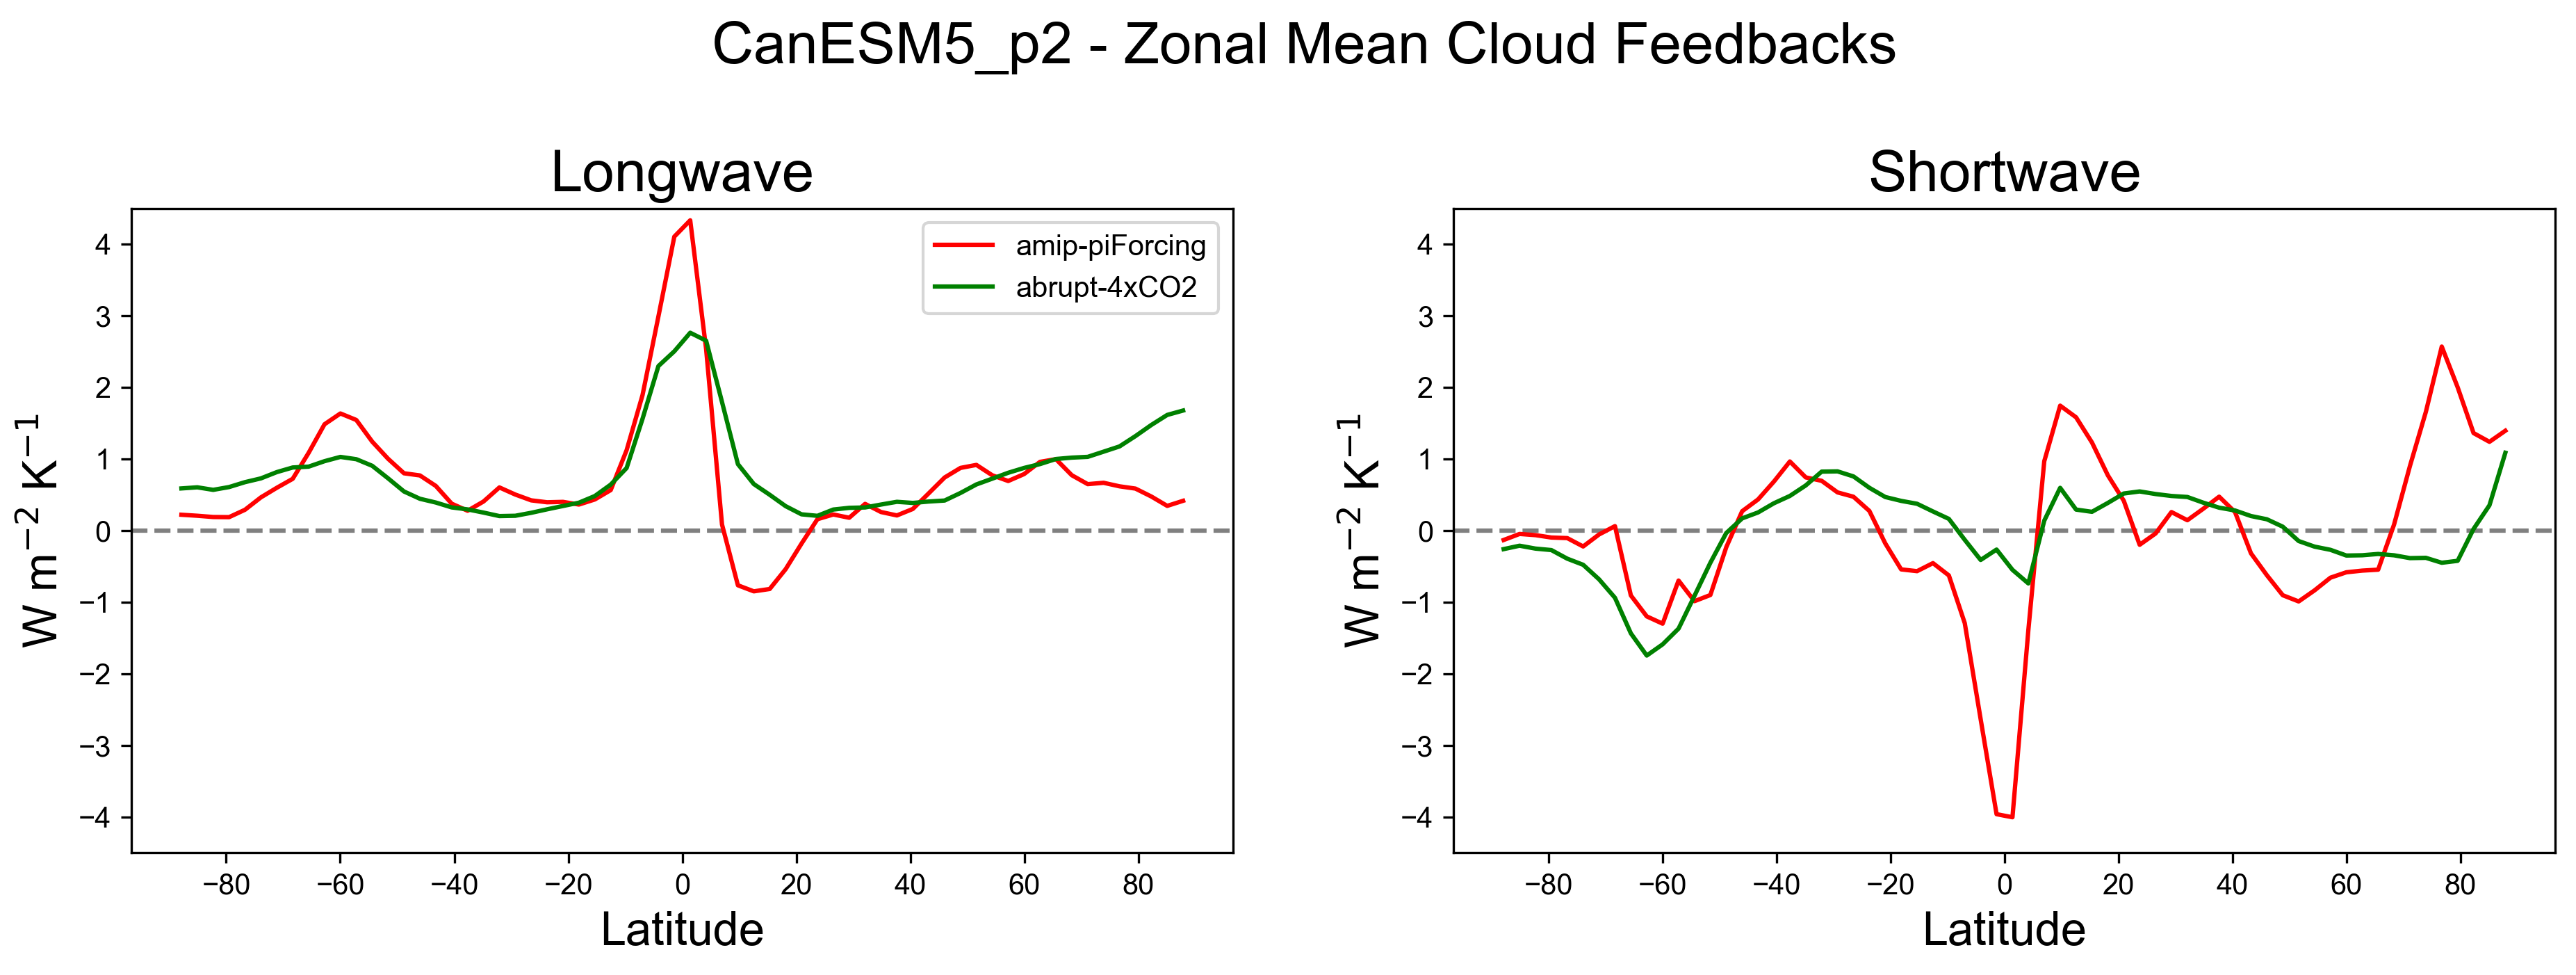

In [5]:
plt.figure(figsize=(15,9),dpi=300)
plt.suptitle('CanESM5_p2 - Zonal Mean Cloud Feedbacks',fontsize=20)
lat = np.linspace(-87.864,87.864,64)
#temperature
plt.subplot(221)
plt.title('Longwave',fontsize=20)
plt.axhline(0,color='grey',linestyle='--')
plt.plot(lat,lwcld_fbk_amip_ZM,label='amip-piForcing',color='red')
plt.plot(lat,lwcld_fbk_ZM,label='abrupt-4xCO2',color='green')
plt.legend()
plt.ylim(-4.5,4.5)
plt.ylabel('W m$^{-2}$ K$^{-1}$',fontsize=16)
plt.xlabel('Latitude',fontsize=16)
plt.xticks(range(-80,81,20))

#water vapour
plt.subplot(222)
plt.title('Shortwave',fontsize=20)
plt.axhline(0,color='grey',linestyle='--')
plt.plot(lat,swcld_fbk_amip_ZM,label='CanESM5_p2 - amip-piForcing',color='red')
plt.plot(lat,swcld_fbk_ZM,label='CanESM5_p2 - abrupt-4xCO2',color='green')
plt.ylim(-4.5,4.5)
plt.ylabel('W m$^{-2}$ K$^{-1}$',fontsize=16)
plt.xlabel('Latitude',fontsize=16)
plt.xticks(range(-80,81,20));


plt.savefig('CanESM5_CLDFB_amip_ZM.png',bbox_inches='tight')

In [6]:
def LinReg_wrap(predictand,predictor):
    fit = LinearRegression().fit(predictor,predictand)
    return fit.coef_

def LinReg_pred_wrap(predictand,predictor):
    fit = LinearRegression().fit(predictor,predictand)
    
    prediction = fit.predict(np.linspace(-0.8,0.4,50).reshape(-1,1))
    return prediction

In [7]:
alphas = dict()
pred = dict()
for eb in fluxes.keys():
    alphas[eb] = LinReg_wrap(fluxes_mn[eb],Tas.reshape(-1,1))
    pred[eb] = LinReg_pred_wrap(fluxes_mn[eb],Tas.reshape(-1,1))

In [8]:
#total sky

alpha_145 = LinReg_wrap(FNET,Tas.reshape(-1,1))
line_145 = LinReg_pred_wrap(FNET,Tas.reshape(-1,1))

alpha_1_48 = LinReg_wrap(FNET[0:48],Tas[0:48].reshape(-1,1))
line_1_48 = LinReg_pred_wrap(FNET[0:48],Tas[0:48].reshape(-1,1))

alpha_48_96 = LinReg_wrap(FNET[48:96],Tas[48:96].reshape(-1,1))
line_48_96 = LinReg_pred_wrap(FNET[48:96],Tas[48:96].reshape(-1,1))

alpha_96_144 = LinReg_wrap(FNET[96:144],Tas[96:144].reshape(-1,1))
line_96_144 = LinReg_pred_wrap(FNET[96:144],Tas[96:144].reshape(-1,1))

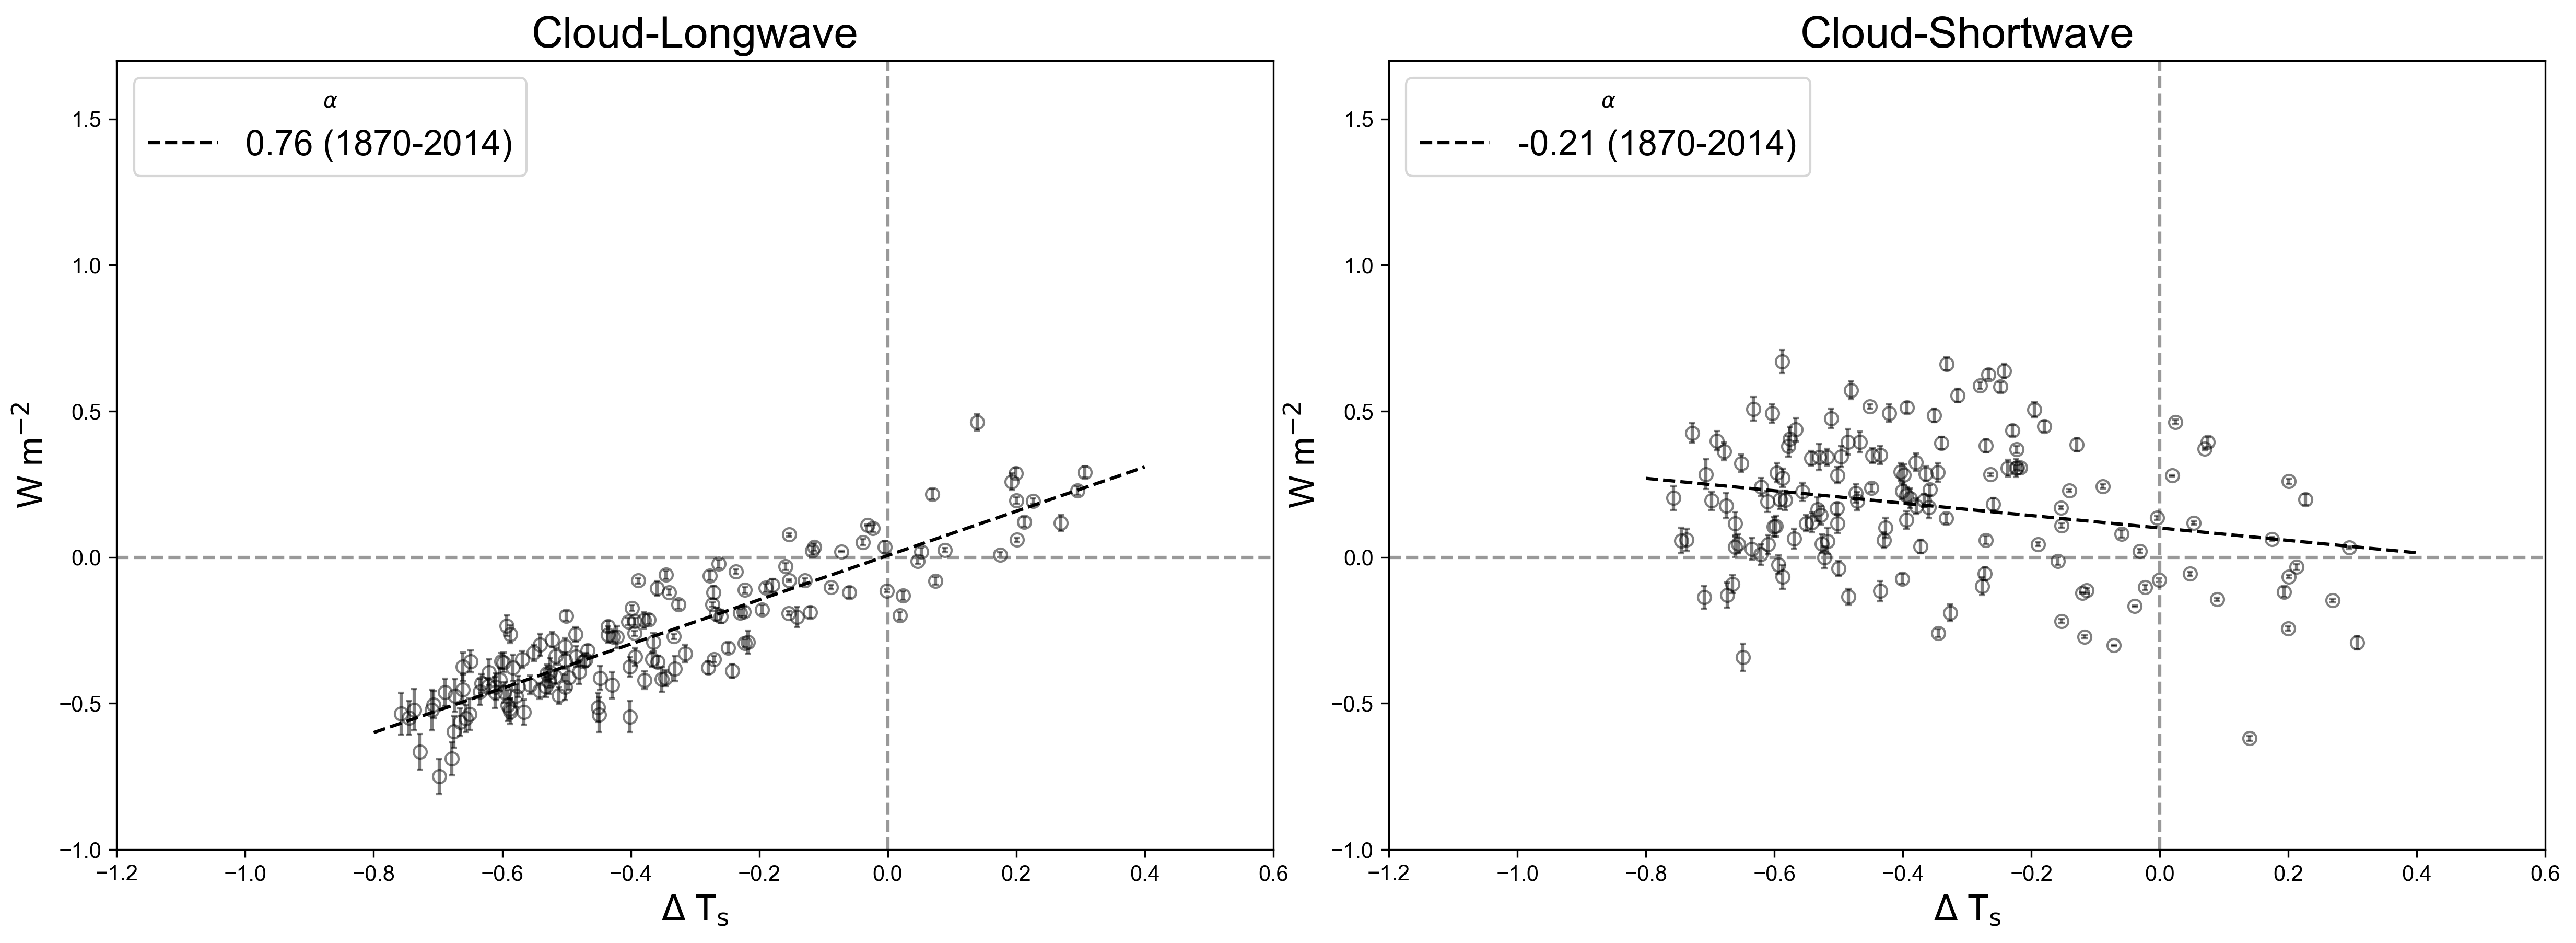

In [11]:
fig = plt.figure(figsize=(20,20/3),dpi=300)

plt.subplot(121)
plt.title('Cloud-Longwave',fontsize=20)
plt.xlim(-1.2,0.6)
plt.ylim(-1,1.7)
plt.xticks(np.arange(-1.2,0.61,0.2));
plt.ylabel('W m$^{-2}$',fontsize=16)
plt.xlabel('$\Delta$ T$_{\mathrm{s}}$',fontsize=16)

plt.errorbar(Tas,fluxes_mn['TrCLlw_FLUX'],\
            yerr=fluxes_std['TrCLlw_FLUX'],ls="None",fmt='o',\
            mfc='none',color='k',capsize=1.5,alpha=0.5)

plt.axvline(0,color='grey',linestyle='--',alpha=0.8)
plt.axhline(0,color='grey',linestyle='--',alpha=0.8)
    
plt.plot(np.linspace(-0.8,0.4,50),pred['TrCLlw_FLUX'],color='k',linestyle='--',\
             label='{} (1870-2014)'.format(round(alphas['TrCLlw_FLUX'][0],2)))

plt.legend(fontsize=16,title=r'$ \alpha $')

plt.subplot(122)
plt.title('Cloud-Shortwave',fontsize=20)
plt.xlim(-1.2,0.6)
plt.ylim(-1,1.7)
plt.xticks(np.arange(-1.2,0.61,0.2));
plt.ylabel('W m$^{-2}$',fontsize=16)
plt.xlabel('$\Delta$ T$_{\mathrm{s}}$',fontsize=16);

plt.errorbar(Tas,fluxes_mn['TrCLsw_FLUX'],\
            yerr=fluxes_std['TrCLsw_FLUX'],ls="None",fmt='o',\
            mfc='none',color='k',capsize=1.5,alpha=0.5)

plt.axvline(0,color='grey',linestyle='--',alpha=0.8)
plt.axhline(0,color='grey',linestyle='--',alpha=0.8)
plt.plot(np.linspace(-0.8,0.4,50),pred['TrCLsw_FLUX'],color='k',linestyle='--',\
             label='{} (1870-2014)'.format(round(alphas['TrCLsw_FLUX'][0],2)))

plt.legend(fontsize=16,title=r'$ \alpha $')

#plt.subplot(gs[2:4, 1:3])
#plt.title('Net TOA Flux',fontsize=20)
#plt.axvline(0,color='grey',linestyle='--',alpha=0.8)
#plt.axhline(0,color='grey',linestyle='--',alpha=0.8)

#plt.plot(np.linspace(-0.8,0.4,50),line_145,color='k',\
#         linestyle='--',label='{} (1870-2014)'.format(round(alpha_145[0],2)))

#plt.plot(Tas,FNET,'o',color='red',mfc='none')
#plt.plot(np.linspace(-0.8,0.4,50),line_1_48,color='red',\
#         linestyle='--',label='{} (Years 1870-1918)'.format(round(alpha_1_48[0],2)))

#plt.plot(Tas[48:],FNET[48:],'o',color='green',mfc='none')
#plt.plot(np.linspace(-0.8,0.4,50),line_48_96,color='green',\
#         linestyle='--',label='{} (Years 1918-1966)'.format(round(alpha_48_96[0],2)))

#plt.plot(Tas[96:],FNET[96:],'o',color='blue',mfc='none')
#plt.plot(np.linspace(-0.8,0.4,50),line_96_144,color='blue',\
#         linestyle='--',label='{} (Years 1966-2014)'.format(round(alpha_96_144[0],2)))



#plot attributes
#plt.legend(title=r'$ \alpha $',fontsize=16)
#plt.xlabel('$\Delta$ T$_{\mathrm{s}}$')
#plt.ylabel('$\Delta$ W m$^{-2}$')
#plt.ylim(-1,1.7)
#plt.xlim(-1.2,0.6)
#plt.xticks(np.arange(-1.2,0.61,0.2));

plt.subplots_adjust(wspace=0.1)
plt.savefig('FLUX_amip_scatter_GAM.png',bbox_inches='tight')